In [1]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.cluster import AgglomerativeClustering as SklearnAgglomerative
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

Custom KMeans

In [2]:
class CustomKMeans:
    def __init__(self, n_clusters=3, init='random', max_iter=300, tol=1e-4, random_state=None, n_init=10):
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.n_init = n_init
        self.centroids = None
        self.labels_ = None
        self.cluster_centers_ = None

    #initializing the centroids
    def _initialize_centroids(self, X):
        rng = np.random.RandomState(self.random_state)
        if self.init == 'random':
            indices = rng.permutation(X.shape[0])[:self.n_clusters]
            return X[indices]
        #implementing k-means++
        elif self.init == 'k-means++':
            centroids = [X[rng.choice(X.shape[0])]]
            for _ in range(1, self.n_clusters):
                dist_sq = np.min([np.linalg.norm(X - c, axis=1)**2 for c in centroids], axis=0)
                probs = dist_sq / dist_sq.sum()
                cumulative_probs = np.cumsum(probs)
                r = rng.rand()
                next_idx = np.searchsorted(cumulative_probs, r)
                centroids.append(X[next_idx])
            return np.array(centroids)

    
    #assigning clusters
    def _assign_clusters(self, X, centroids):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        return np.argmin(distances, axis=1)

    #computing centroids
    def _compute_centroids(self, X, labels):
        return np.array([X[labels == i].mean(axis=0) if np.any(labels == i) else self.centroids[i]
                         for i in range(self.n_clusters)])

    def _has_converged(self, old_centroids, new_centroids):
        return np.linalg.norm(new_centroids - old_centroids) < self.tol

    def fit(self, X):
        X = np.asarray(X)
        best_inertia = np.inf
        best_centroids = None
        best_labels = None

        #Runs the KMeans algorithm n_init times and pick the best result
        for _ in range(self.n_init):
            self.centroids = self._initialize_centroids(X)

            for _ in range(self.max_iter):
                labels = self._assign_clusters(X, self.centroids)
                new_centroids = self._compute_centroids(X, labels)
                if self._has_converged(self.centroids, new_centroids):
                    break
                self.centroids = new_centroids

            inertia = np.sum((X - self.centroids[labels]) ** 2)

            #Keeps the best solution based on inertia
            if inertia < best_inertia:
                best_inertia = inertia
                best_centroids = self.centroids
                best_labels = labels

        self.centroids = best_centroids
        self.labels_ = best_labels
        self.cluster_centers_ = best_centroids
        return self

    def predict(self, X):
        X = np.asarray(X)
        return self._assign_clusters(X, self.centroids)

    def fit_predict(self, X):
        return self.fit(X).labels_

    def score(self, X):
        return silhouette_score(X, self.labels_)

Agglomerative Clustering (Bottom-Up)

In [3]:
class CustomAgglomerativeClustering:
    def __init__(self, n_clusters=2, linkage='single'):
        self.n_clusters = n_clusters
        self.linkage = linkage

    def fit(self, X):
        self.X = np.asarray(X)
        n_samples = len(X)
        self.labels_ = np.arange(n_samples) #creating clusters
        self.clusters = {i: [i] for i in range(n_samples)}

        distance_matrix = cdist(X, X) #computing pairwise distance matrix between points
        np.fill_diagonal(distance_matrix, np.inf)

        while len(self.clusters) > self.n_clusters: #merge clusters until desired numebr reached
            min_dist = np.inf
            to_merge = (None, None)

            for i in self.clusters: #finding sallest cluster par
                for j in self.clusters:
                    if i >= j: #avoiding duplicates
                        continue
                    dist = self._linkage_distance(self.clusters[i], self.clusters[j], distance_matrix)
                    if dist < min_dist:
                        min_dist = dist
                        to_merge = (i, j)

            i, j = to_merge #merging closets pair of clusters
            self.clusters[i].extend(self.clusters[j])
            del self.clusters[j]
            for idx in self.clusters[i]: #updating labels for points in merged cluster
                self.labels_[idx] = i

        #relabel
        final_clusters = {cid: idx for idx, cid in enumerate(self.clusters)}
        self.labels_ = np.array([final_clusters[label] for label in self.labels_])
        return self
    
    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

    def _linkage_distance(self, cluster1, cluster2, distance_matrix):
        if self.linkage == 'single': #nearest neighbor
            return np.min([distance_matrix[i][j] for i in cluster1 for j in cluster2])
        elif self.linkage == 'complete': #farthest neighbor
            return np.max([distance_matrix[i][j] for i in cluster1 for j in cluster2])
        elif self.linkage == 'average': #average pairwise distance
            return np.mean([distance_matrix[i][j] for i in cluster1 for j in cluster2])
        elif self.linkage == 'ward': #squared distance between centroids
            # Calculate centroids for cluster1 and cluster2
            centroid1 = np.mean(self.X[cluster1], axis=0)
            centroid2 = np.mean(self.X[cluster2], axis=0)

            # Compute the squared Euclidean distance between the centroids
            return np.linalg.norm(centroid1 - centroid2) ** 2
        else:
            raise ValueError("Unknown linkage type: {}".format(self.linkage))


Objective Functions ( Linkage ):
- Single - Distance between closest points in clusters; Tends to create "chain" clusters
- Complete - Distance between farthest points; Prefers compact, spherical clusters
- Average - Average pairwise distance between all points; Balances chaining and compactness
- Ward- Minimize increase in total within-cluster variance; Similar to KMeans objective

- Only 'ward' linkage resembles a loss funtion while the rest are heuristics

Testing with make_blobs dataset against Sklearn

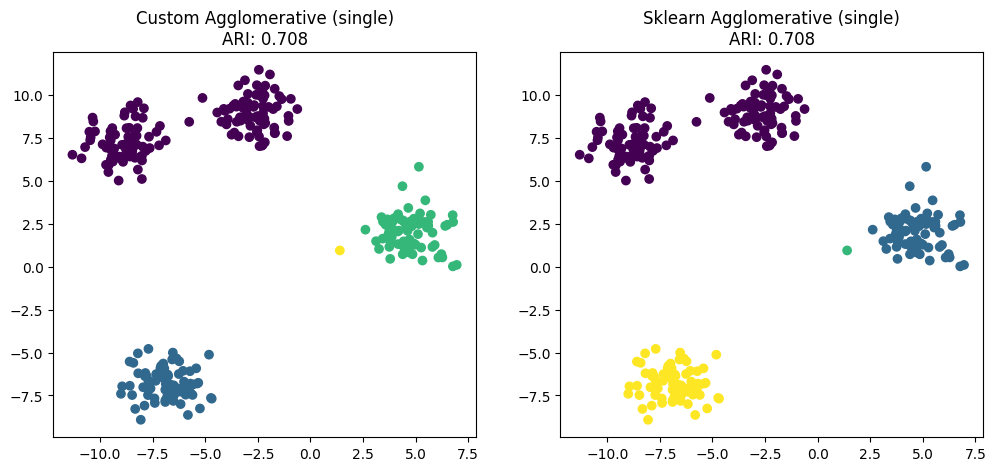

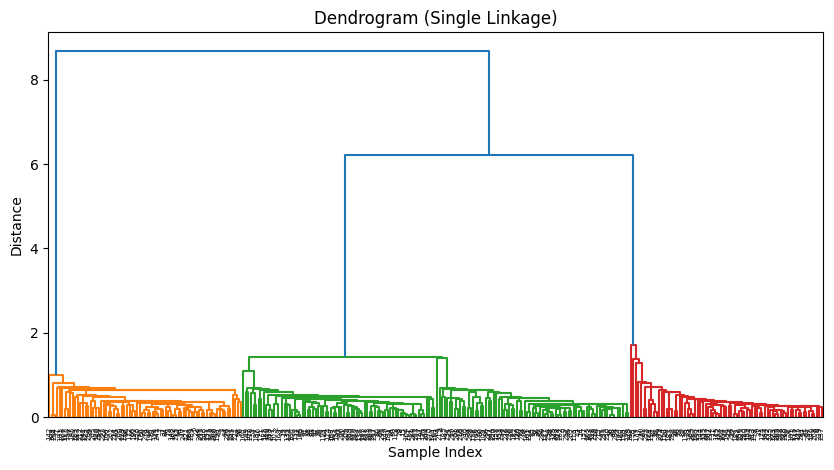

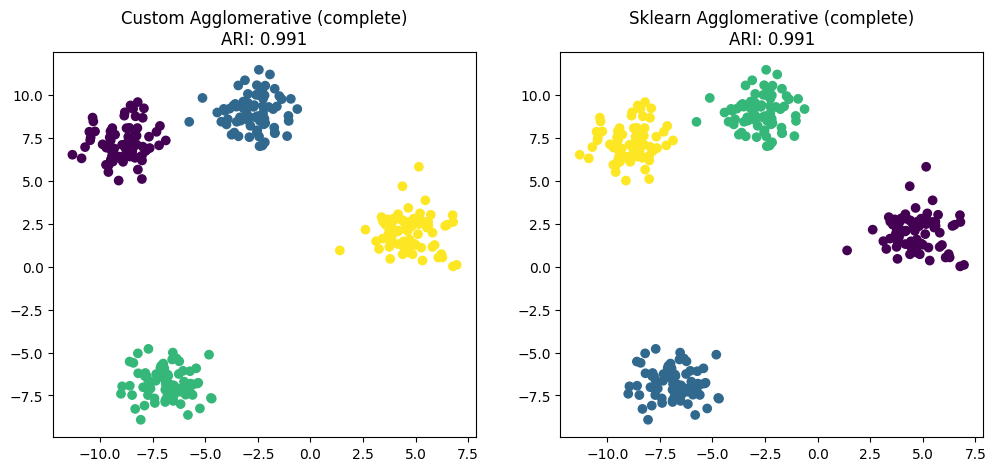

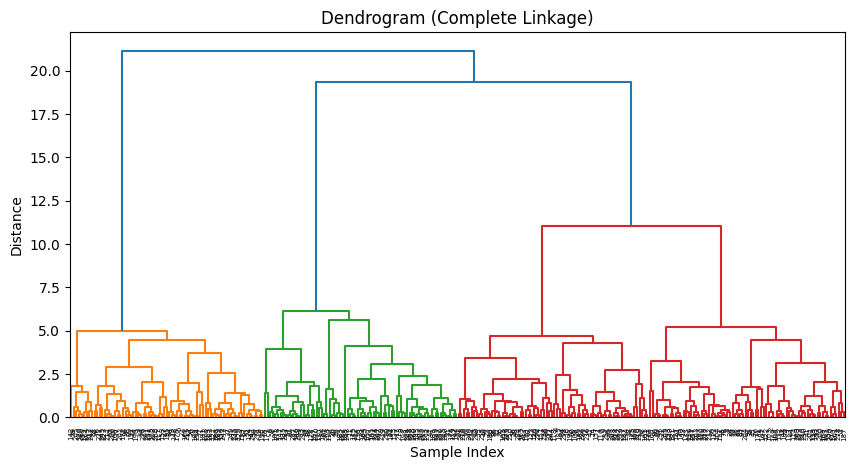

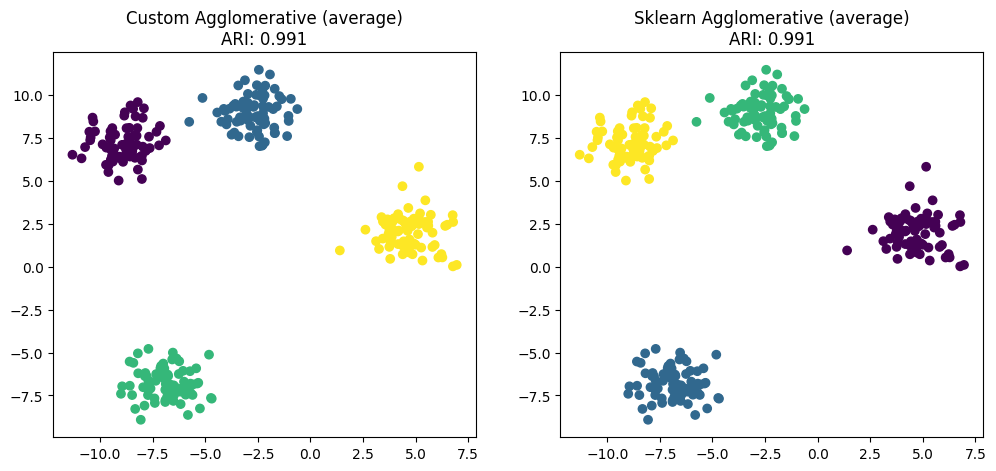

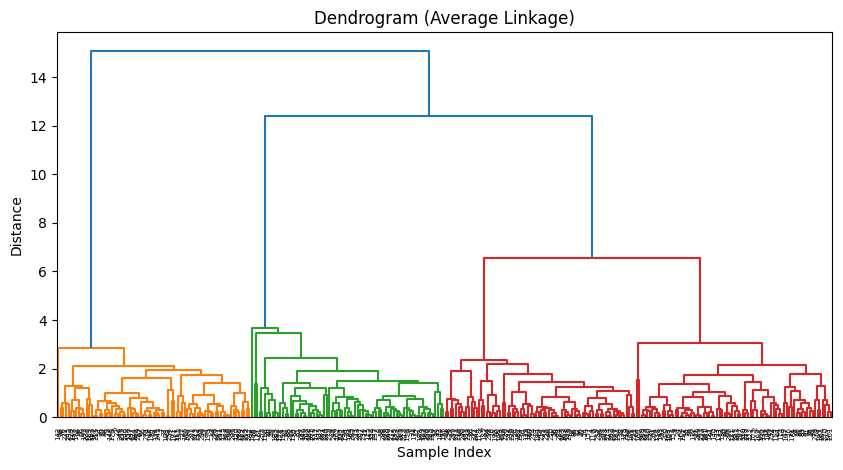

In [4]:
X_blobs, y_blobs = make_blobs(n_samples=300, centers=4, random_state=42)

for method in ['single', 'complete', 'average']:
    # Custom model
    custom_model = CustomAgglomerativeClustering(n_clusters=4, linkage=method)
    custom_model.fit(X_blobs)
    score = adjusted_rand_score(y_blobs, custom_model.labels_)
    # Sklearn model
    sklearn_model = SklearnAgglomerative(n_clusters=4, linkage=method)
    sklearn_labels = sklearn_model.fit_predict(X_blobs)
    sk_score = adjusted_rand_score(y_blobs, sklearn_labels)
    # Plot comparison
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].scatter(X_blobs[:, 0], X_blobs[:, 1], c=custom_model.labels_, cmap='viridis')
    axs[0].set_title(f"Custom Agglomerative ({method})\nARI: {score:.3f}")
    
    axs[1].scatter(X_blobs[:, 0], X_blobs[:, 1], c=sklearn_labels, cmap='viridis')
    axs[1].set_title(f"Sklearn Agglomerative ({method})\nARI: {sk_score:.3f}")

    plt.show()

    # Dendrogram
    Z = linkage(X_blobs, method=method)
    plt.figure(figsize=(10, 5))
    dendrogram(Z)
    plt.title(f"Dendrogram ({method.capitalize()} Linkage)")
    plt.xlabel("Sample Index")
    plt.ylabel("Distance")
    plt.show()

Testing with make_moons dataset against Sklearn

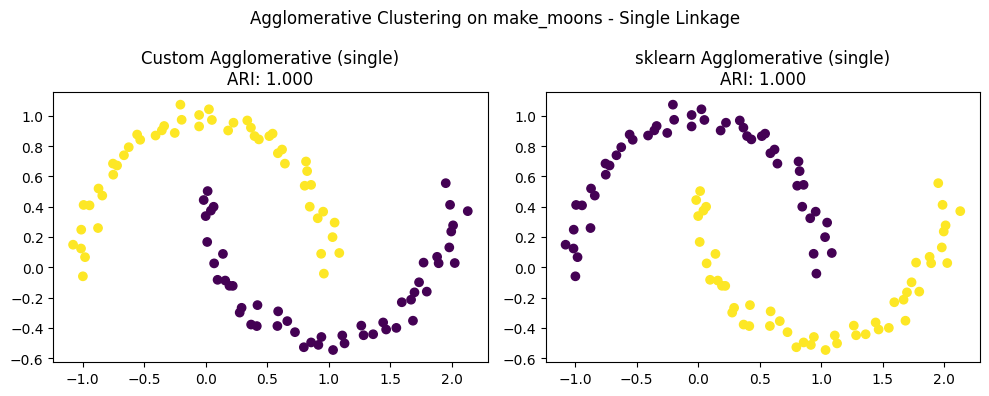

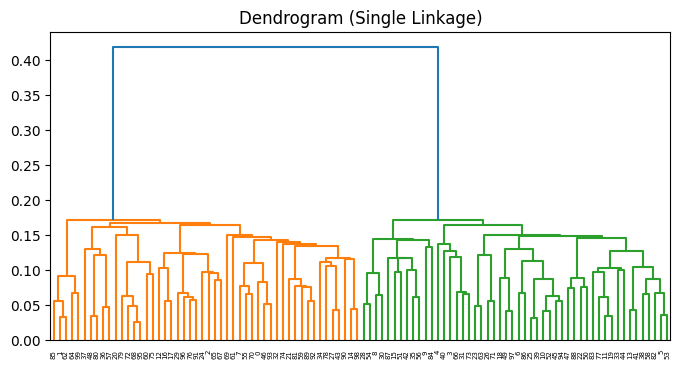

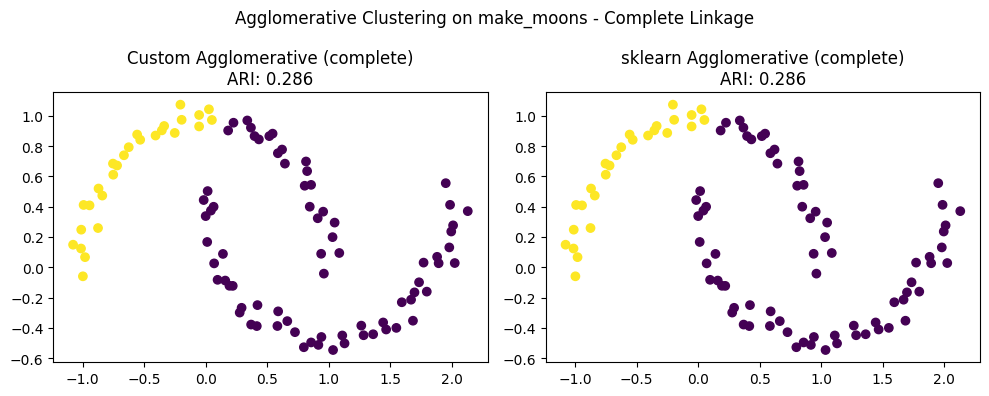

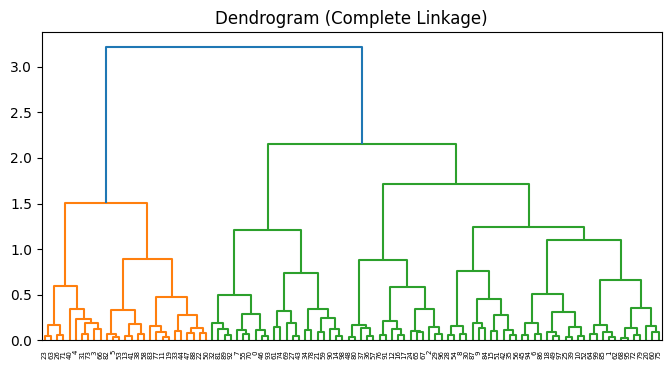

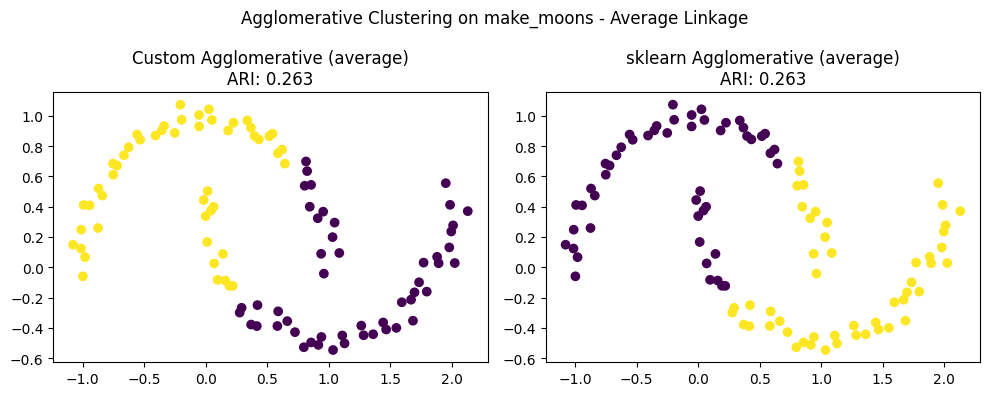

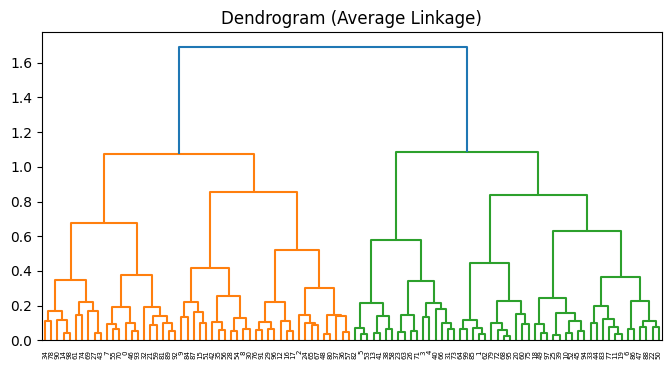

In [5]:
#Data and Plot Functions
X_moons, y_moons = make_moons(n_samples=100, noise=0.05, random_state=42)

for method in ['single', 'complete', 'average']:
    model = CustomAgglomerativeClustering(n_clusters=2, linkage=method)
    model.fit(X_moons)
    score = adjusted_rand_score(y_moons, model.labels_)

    # Plot custom clustering
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(X_moons[:, 0], X_moons[:, 1], c=model.labels_, cmap='viridis')
    plt.title(f"Custom Agglomerative ({method})\nARI: {score:.3f}")

    # Scikit-learn version
    sk_model = SklearnAgglomerative(n_clusters=2, linkage=method)
    sk_labels = sk_model.fit_predict(X_moons)
    sk_score = adjusted_rand_score(y_moons, sk_labels)

    plt.subplot(1, 2, 2)
    plt.scatter(X_moons[:, 0], X_moons[:, 1], c=sk_labels, cmap='viridis')
    plt.title(f"sklearn Agglomerative ({method})\nARI: {sk_score:.3f}")

    plt.suptitle(f"Agglomerative Clustering on make_moons - {method.capitalize()} Linkage")
    plt.tight_layout()
    plt.show()

    # Dendrogram
    Z = linkage(X_moons, method=method)
    plt.figure(figsize=(8, 4))
    dendrogram(Z)
    plt.title(f"Dendrogram ({method.capitalize()} Linkage)")
    plt.show()

Testing with make_circles dataset against Sklearn


Single Linkage
Custom Agglomerative ARI: 1.000
Sklearn Agglomerative ARI: 1.000


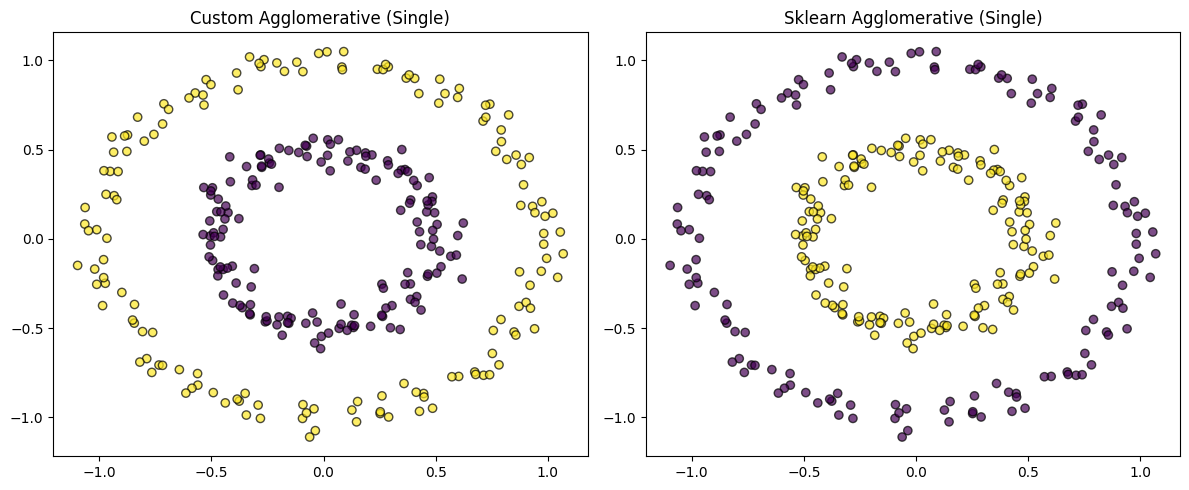

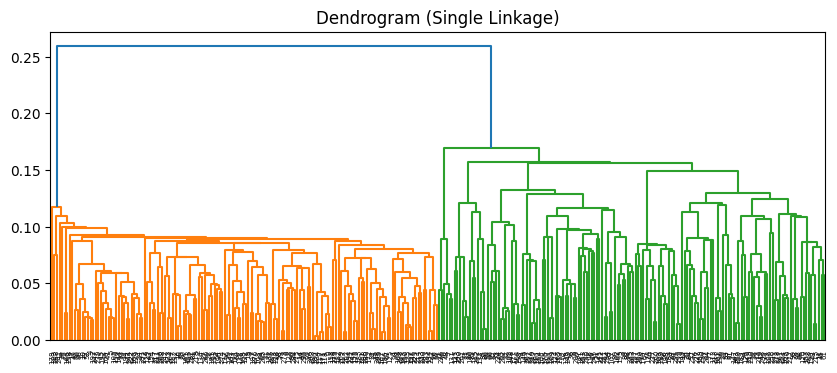


Complete Linkage
Custom Agglomerative ARI: -0.002
Sklearn Agglomerative ARI: -0.002


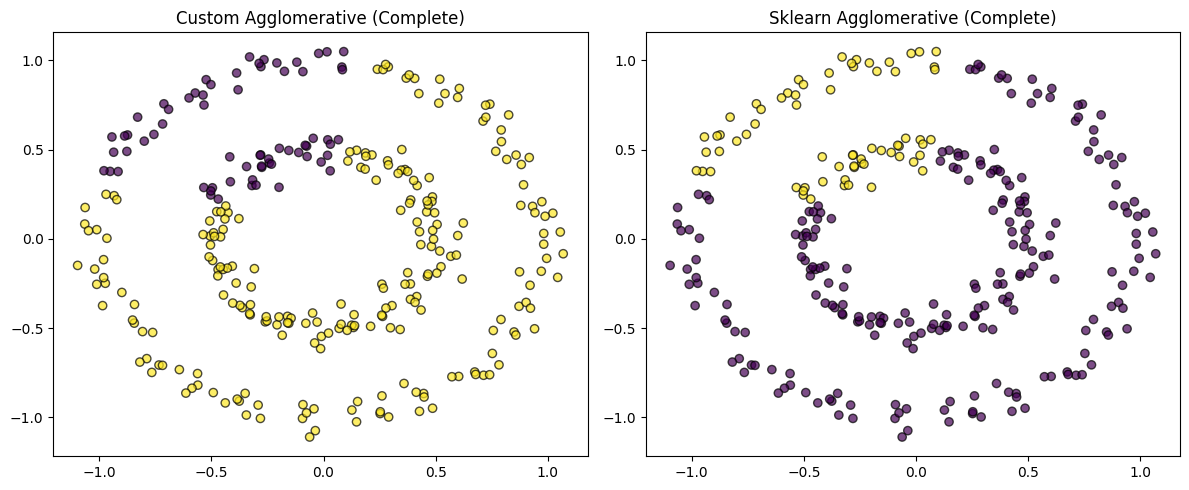

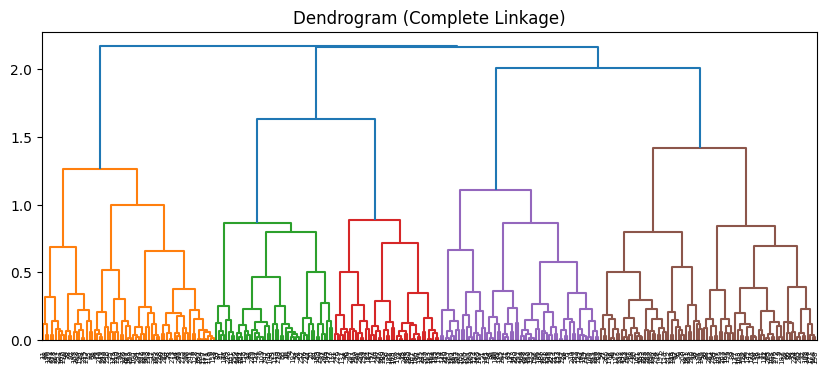


Average Linkage
Custom Agglomerative ARI: 0.001
Sklearn Agglomerative ARI: 0.001


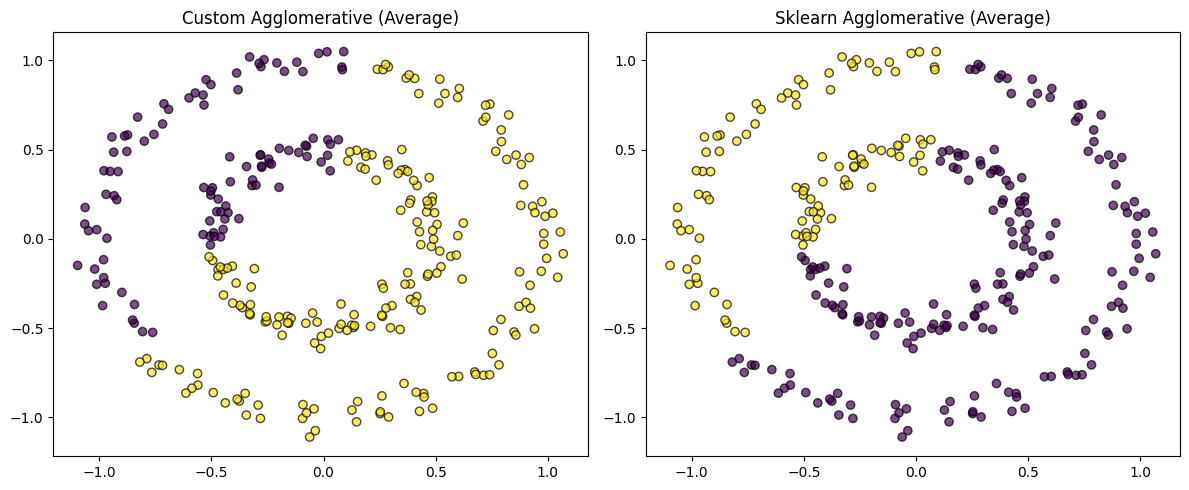

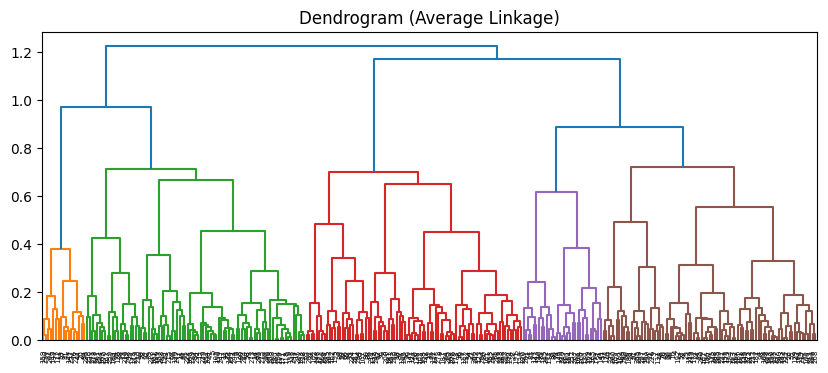

In [6]:
X_circles, y_circles = make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=42)

# Loop through linkage methods
for method in ['single', 'complete', 'average']:
    # Custom Agglomerative
    model = CustomAgglomerativeClustering(n_clusters=2, linkage=method)
    model.fit(X_circles)
    ari_custom = adjusted_rand_score(y_circles, model.labels_)

    # Scikit-learn Agglomerative
    sk_model = SklearnAgglomerative(n_clusters=2, linkage=method)
    sk_labels = sk_model.fit_predict(X_circles)
    ari_sklearn = adjusted_rand_score(y_circles, sk_labels)

    print(f"\n{method.capitalize()} Linkage")
    print(f"Custom Agglomerative ARI: {ari_custom:.3f}")
    print(f"Sklearn Agglomerative ARI: {ari_sklearn:.3f}")

    # --- Side-by-side plots for clustering results ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].scatter(X_circles[:, 0], X_circles[:, 1], c=model.labels_, cmap='viridis', edgecolors='k', alpha=0.7)
    axes[0].set_title(f"Custom Agglomerative ({method.capitalize()})")

    axes[1].scatter(X_circles[:, 0], X_circles[:, 1], c=sk_labels, cmap='viridis', edgecolors='k', alpha=0.7)
    axes[1].set_title(f"Sklearn Agglomerative ({method.capitalize()})")

    plt.tight_layout()
    plt.show()

    # --- Dendrogram separately ---
    linked = linkage(X_circles, method=method)
    plt.figure(figsize=(10, 4))
    dendrogram(linked)
    plt.title(f"Dendrogram ({method.capitalize()} Linkage)")
    plt.show()

Testing vs Sklearn on different k-valuess

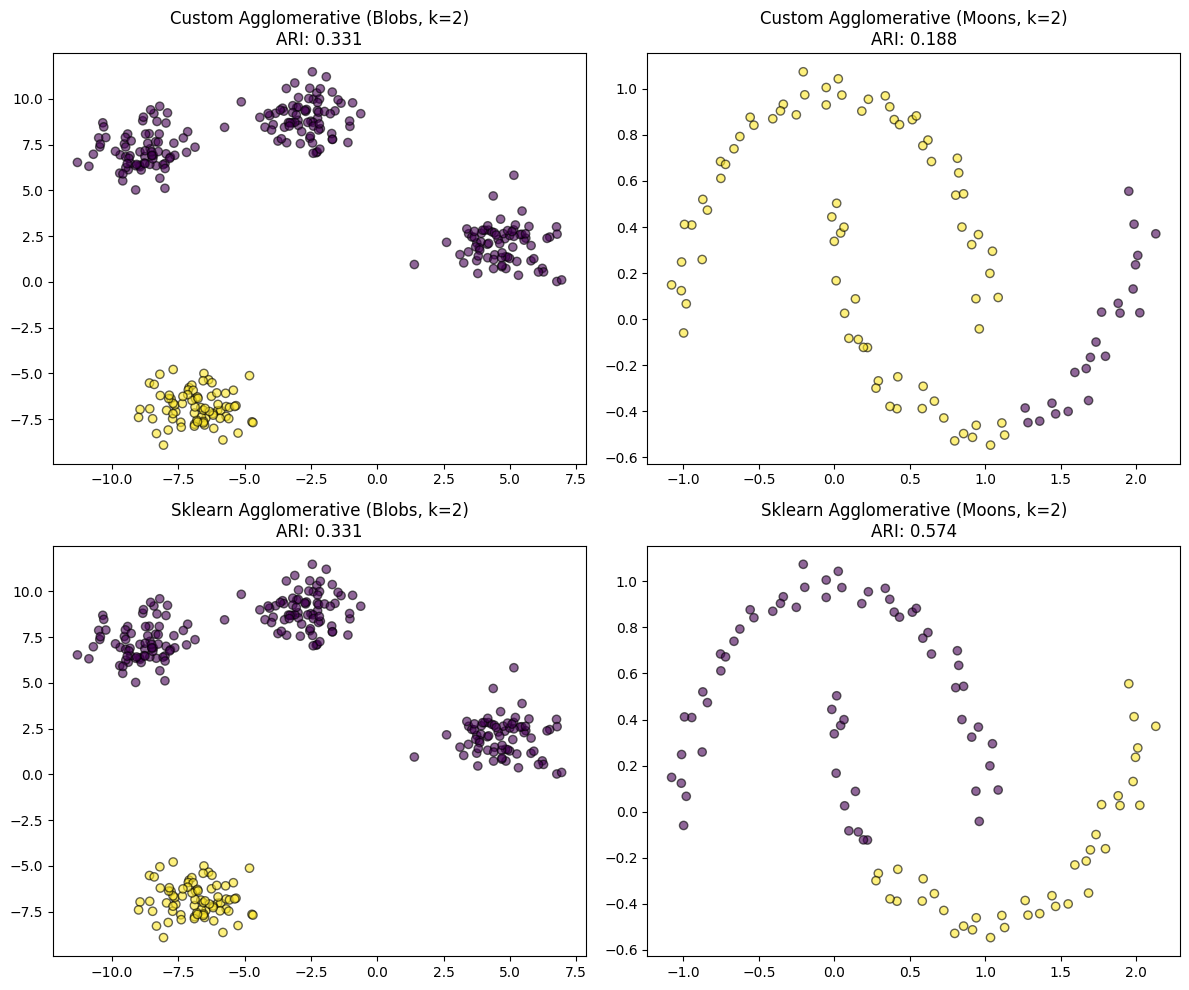

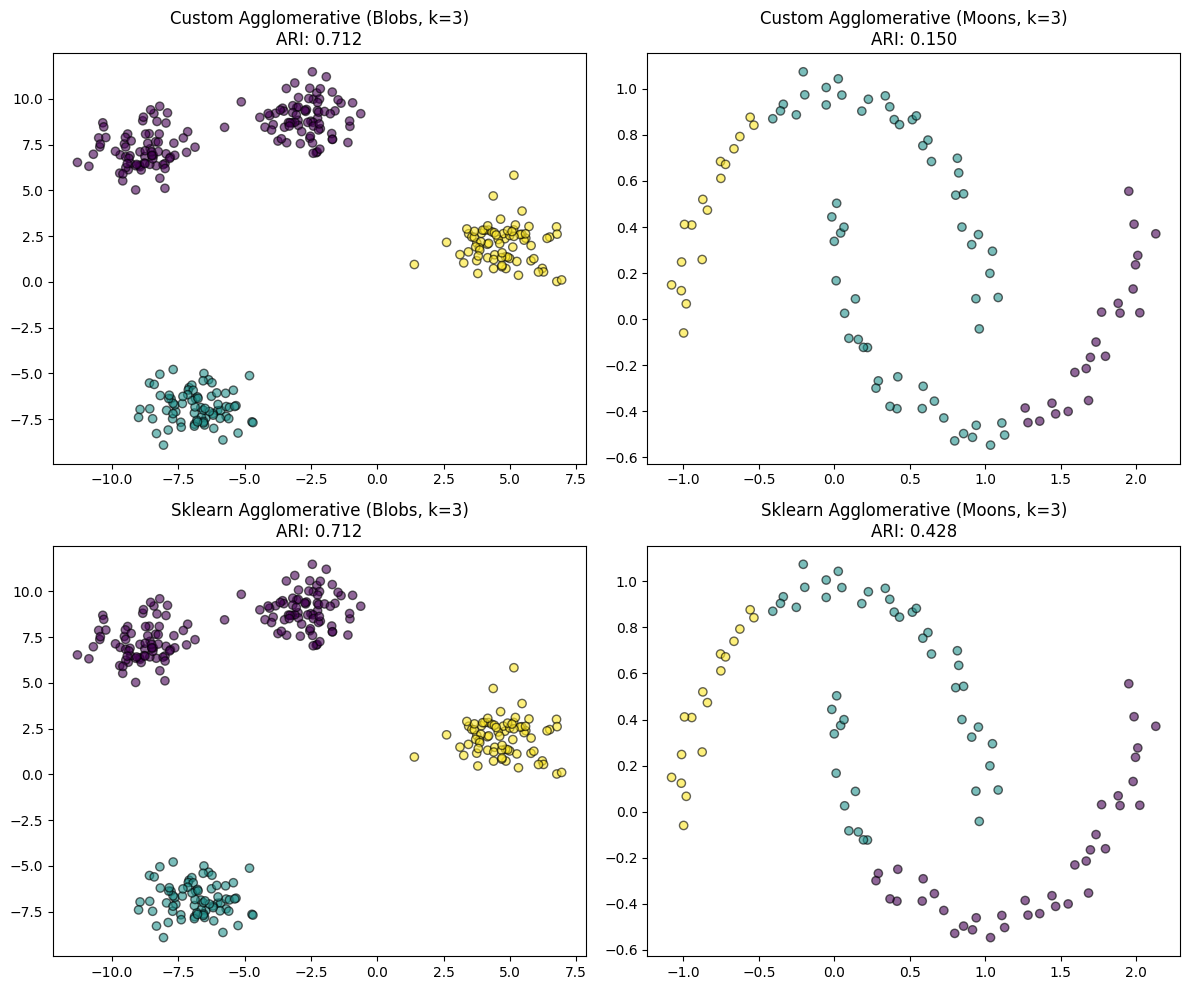

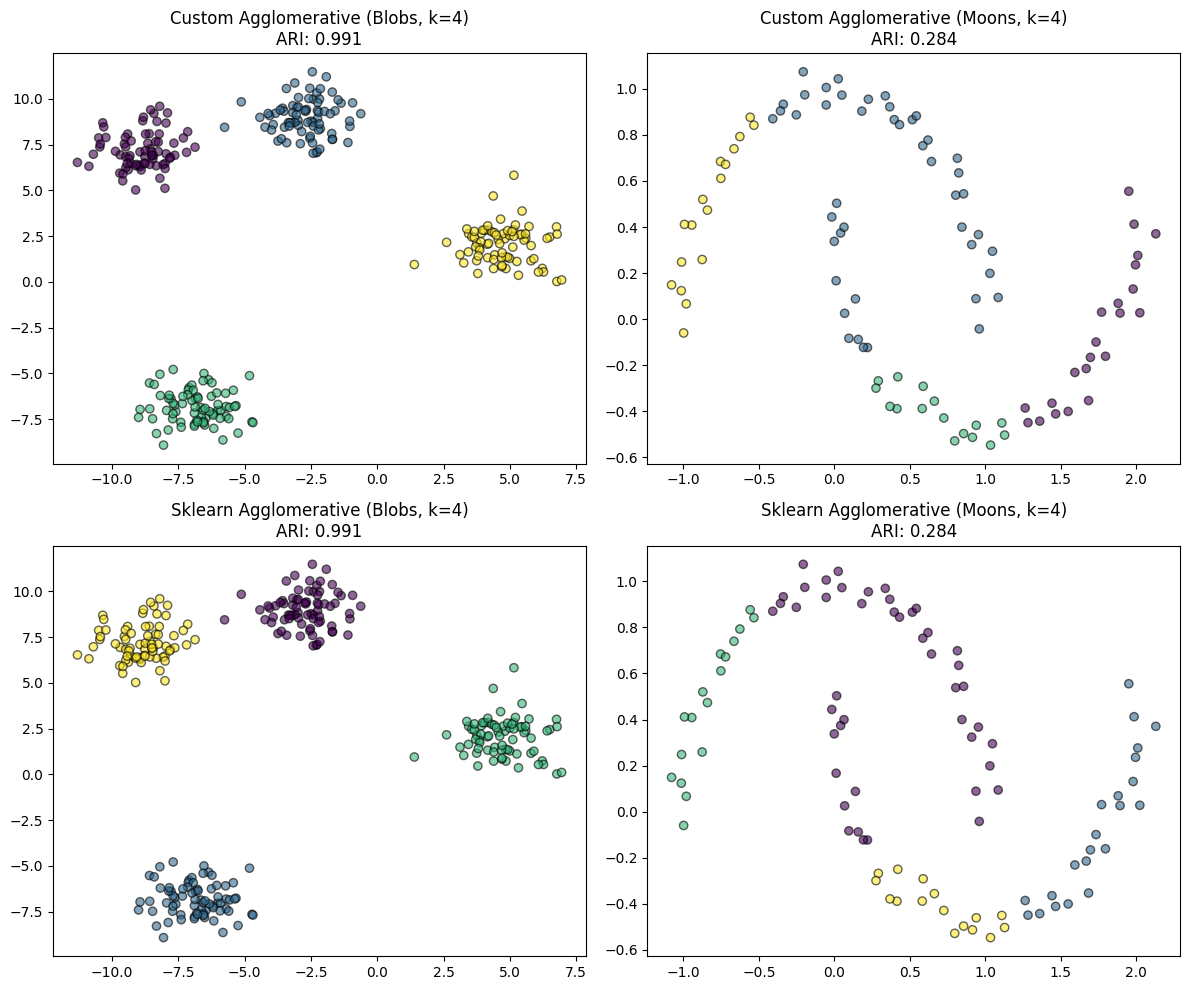

In [7]:
# Function to plot clustering results
def plot_clusters(X, labels, title, ax, true_labels):
    ari = adjusted_rand_score(true_labels, labels)
    ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', edgecolors='k', alpha=0.6)
    ax.set_title(f"{title}\nARI: {ari:.3f}")


for n_clusters in [2, 3, 4]:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid for 4 plots
    
    # Custom Agglomerative on Blobs
    agg_clustering_blobs = CustomAgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    labels_blobs = agg_clustering_blobs.fit_predict(X_blobs)
    plot_clusters(X_blobs, labels_blobs, f'Custom Agglomerative (Blobs, k={n_clusters})', axes[0, 0], y_blobs)

    # Custom Agglomerative on Moons
    agg_clustering_moons = CustomAgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    labels_moons = agg_clustering_moons.fit_predict(X_moons)
    plot_clusters(X_moons, labels_moons, f'Custom Agglomerative (Moons, k={n_clusters})', axes[0, 1], y_moons)

    # Sklearn Agglomerative on Blobs
    sklearn_clustering_blobs = SklearnAgglomerative(n_clusters=n_clusters, linkage='ward')
    sk_labels_blobs = sklearn_clustering_blobs.fit_predict(X_blobs)
    plot_clusters(X_blobs, sk_labels_blobs, f'Sklearn Agglomerative (Blobs, k={n_clusters})', axes[1, 0], y_blobs)

    # Sklearn Agglomerative on Moons
    sklearn_clustering_moons = SklearnAgglomerative(n_clusters=n_clusters, linkage='ward')
    sk_labels_moons = sklearn_clustering_moons.fit_predict(X_moons)
    plot_clusters(X_moons, sk_labels_moons, f'Sklearn Agglomerative (Moons, k={n_clusters})', axes[1, 1], y_moons)

    plt.tight_layout()
    plt.show()

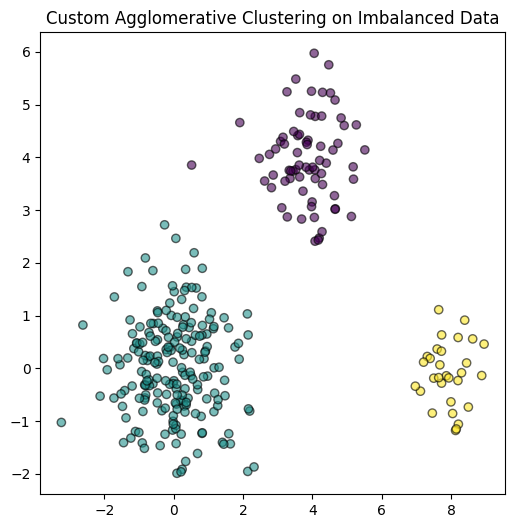

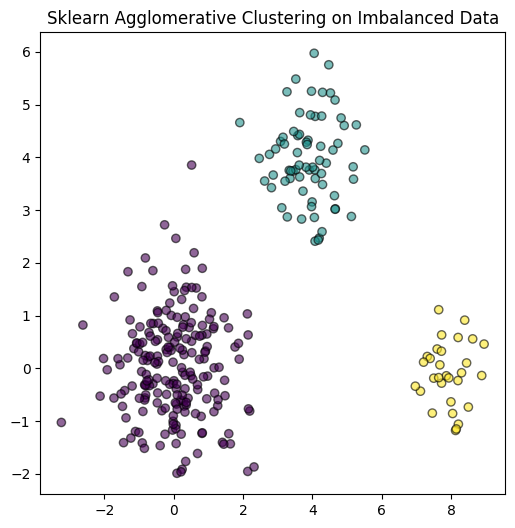

In [8]:
#Unbalanced datasets
from sklearn.utils import shuffle
X_large, _ = make_blobs(n_samples=200, centers=[[0, 0]], cluster_std=1.0, random_state=42)
X_medium, _ = make_blobs(n_samples=70, centers=[[4, 4]], cluster_std=0.8, random_state=42)
X_small, _ = make_blobs(n_samples=30, centers=[[8, 0]], cluster_std=0.6, random_state=42)
X_imbalanced = np.vstack((X_large, X_medium, X_small))
X_imbalanced = shuffle(X_imbalanced, random_state=42)

# Run Agglomerative Clustering on imbalanced data
agg_clustering_imbalanced = CustomAgglomerativeClustering(n_clusters=3, linkage='ward')
labels_imbalanced = agg_clustering_imbalanced.fit_predict(X_imbalanced)

# Plot Agglomerative Clustering on Imbalanced Data
plt.figure(figsize=(6, 6))
plt.scatter(X_imbalanced[:, 0], X_imbalanced[:, 1], c=labels_imbalanced, cmap='viridis', edgecolors='k', alpha=0.6)
plt.title('Custom Agglomerative Clustering on Imbalanced Data')
plt.show()

sklearn_clustering_imbalanced = SklearnAgglomerative(n_clusters=3, linkage='ward')
labels_imbalanced = sklearn_clustering_imbalanced.fit_predict(X_imbalanced)

# Plot Agglomerative Clustering on Imbalanced Data
plt.figure(figsize=(6, 6))
plt.scatter(X_imbalanced[:, 0], X_imbalanced[:, 1], c=labels_imbalanced, cmap='viridis', edgecolors='k', alpha=0.6)
plt.title('Sklearn Agglomerative Clustering on Imbalanced Data')
plt.show()

In [9]:
from sklearn.datasets import load_iris, load_wine
from sklearn.preprocessing import StandardScaler

#Load datasets
iris = load_iris()
wine = load_wine()

#Features and true labels
X_iris = StandardScaler().fit_transform(iris.data)
y_iris = iris.target

X_wine = StandardScaler().fit_transform(wine.data)
y_wine = wine.target


In [10]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score

#Custom Iris
custom_iris = CustomAgglomerativeClustering(n_clusters=3, linkage='ward')
custom_labels_iris = custom_iris.fit_predict(X_iris)
custom_ari_iris = adjusted_rand_score(y_iris, custom_labels_iris)
print(f"Custom Iris ARI: {custom_ari_iris:.3f}")

#Sklearn Iris
agg_iris = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_iris = agg_iris.fit_predict(X_iris)
ari_iris = adjusted_rand_score(y_iris, labels_iris)
print(f"Iris ARI: {ari_iris:.3f}")

#Custom Wine
custom_wine = CustomAgglomerativeClustering(n_clusters=3, linkage='ward')
custom_labels_wine = custom_wine.fit_predict(X_wine)
custom_ari_wine = adjusted_rand_score(y_wine, custom_labels_wine)
print(f"Custom Wine ARI: {custom_ari_wine:.3f}")

#Sklearn Wine
agg_wine = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_wine = agg_wine.fit_predict(X_wine)
ari_wine = adjusted_rand_score(y_wine, labels_wine)
print(f"Wine ARI: {ari_wine:.3f}")


Custom Iris ARI: 0.562
Iris ARI: 0.615
Custom Wine ARI: -0.007
Wine ARI: 0.790


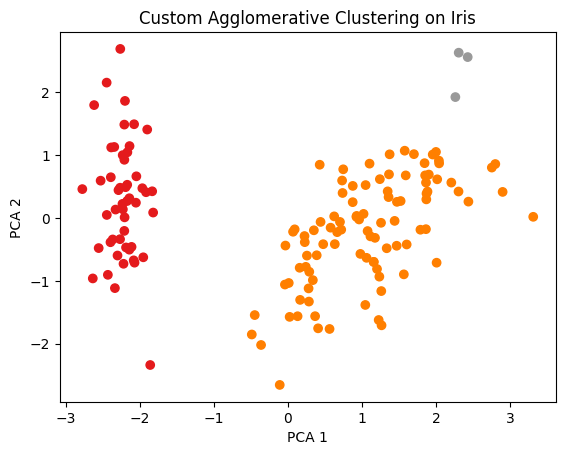

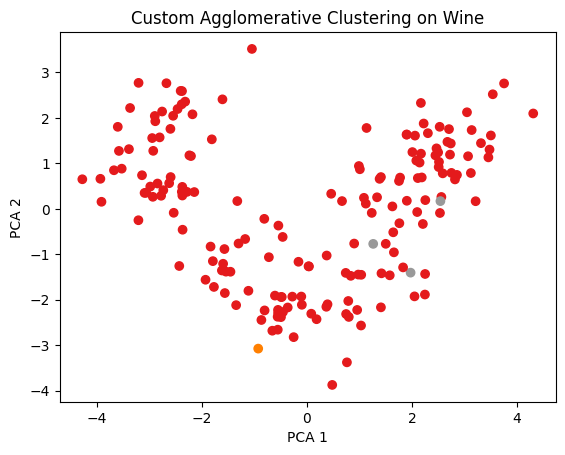

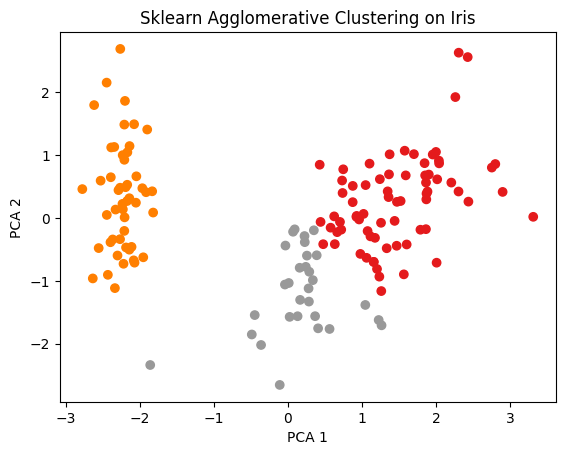

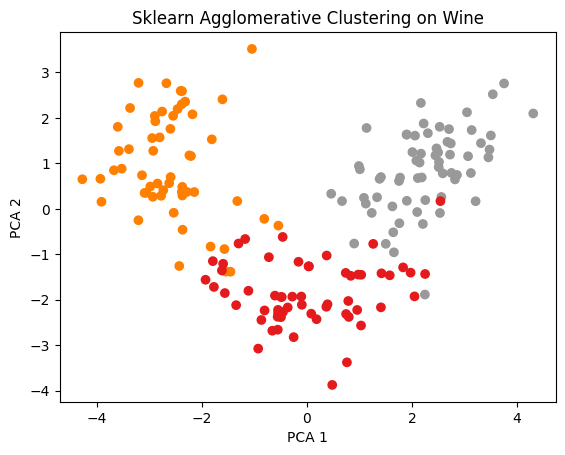

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_clusters(X, labels, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='Set1')
    plt.title(title)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.show()

plot_clusters(X_iris, custom_labels_iris, "Custom Agglomerative Clustering on Iris")
plot_clusters(X_wine, custom_labels_wine, "Custom Agglomerative Clustering on Wine")
plot_clusters(X_iris, labels_iris, "Sklearn Agglomerative Clustering on Iris")
plot_clusters(X_wine, labels_wine, "Sklearn Agglomerative Clustering on Wine")


Divisive Clustering (Top-Down)

In [12]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [13]:
class CustomDivisiveClustering:
    def __init__(self, n_clusters=2):
        self.n_clusters = n_clusters

    def fit(self, X):
        self.X = np.asarray(X)
        n_samples = len(X)
        self.labels_ = np.zeros(n_samples)
        
        #Create the initial single cluster containing all points
        clusters = [list(range(n_samples))]
        
        while len(clusters) < self.n_clusters:
            #Choose the cluster to split (the one with the maximum internal distance)
            cluster_to_split = self._select_cluster_to_split(clusters)
            cluster_data = self.X[clusters[cluster_to_split]]
            
            #Split the cluster into two subclusters
            labels = self._split_cluster(cluster_data)
            
            #Update the clusters
            new_clusters = [clusters[i] for i in range(len(clusters)) if i != cluster_to_split]
            new_clusters.append(np.array(clusters[cluster_to_split])[labels == 0])
            new_clusters.append(np.array(clusters[cluster_to_split])[labels == 1])
            
            clusters = new_clusters
        
        #Assign the final labels
        for i, cluster in enumerate(clusters):
            self.labels_[cluster] = i
        return self

    def _select_cluster_to_split(self, clusters):
        max_dist = -np.inf
        cluster_idx = 0
        #Select the cluster with the maximum average internal distance
        for i, cluster in enumerate(clusters):
            cluster_data = self.X[cluster]
            dist_matrix = cdist(cluster_data, cluster_data)
            np.fill_diagonal(dist_matrix, np.inf)  #Ignore self distances
            avg_dist = np.mean(dist_matrix)
            if avg_dist > max_dist:
                max_dist = avg_dist
                cluster_idx = i
        return cluster_idx
    
    def _split_cluster(self, cluster_data):
        #Use KMeans to split the cluster into two subclusters (could also use other methods)
        kmeans = CustomKMeans(n_clusters=2, random_state=42)
        kmeans.fit(cluster_data)
        return kmeans.labels_

Adjusted Rand Index (Custom Divisive): 1.000
Adjusted Rand Index (Sklearn Agglomerative): 1.000


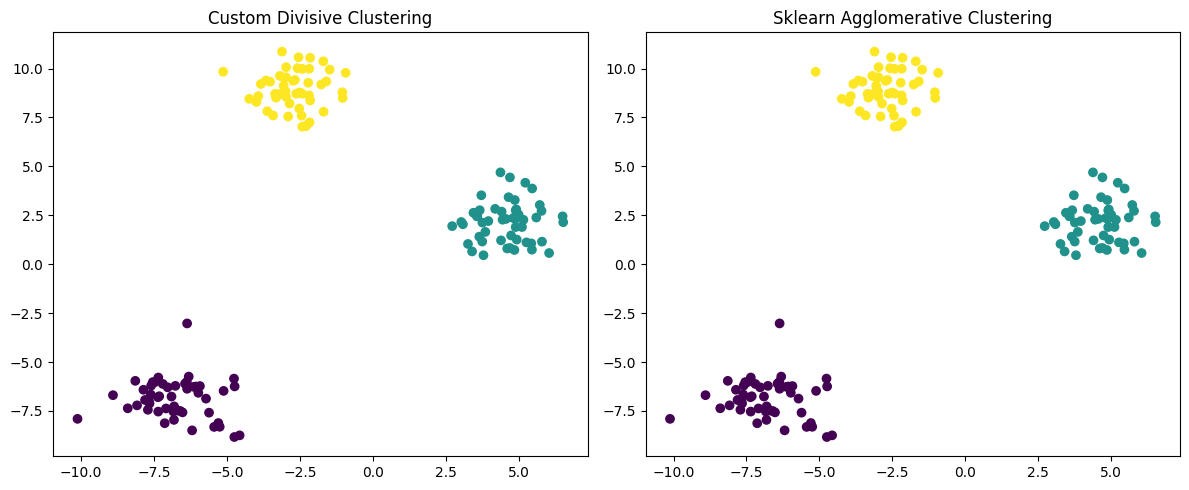

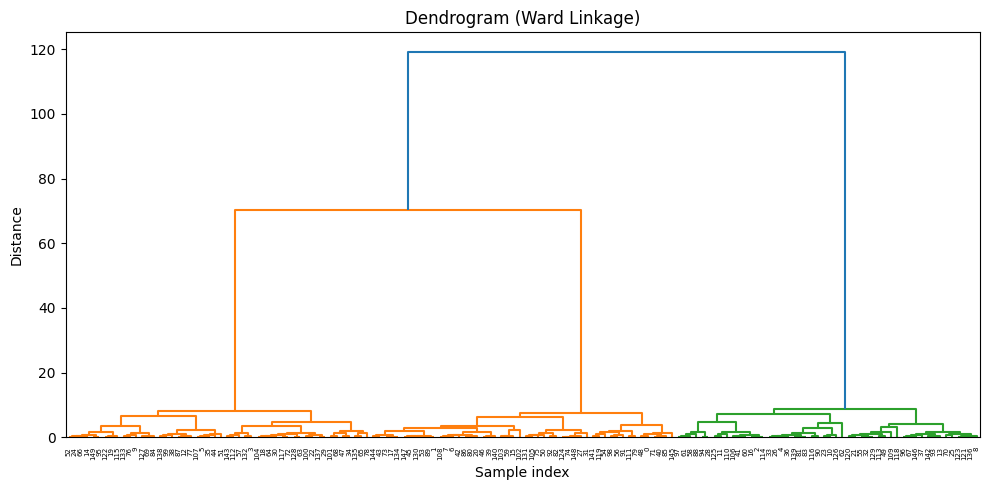

In [14]:
X, y_true = make_blobs(n_samples=150, centers=3, cluster_std=1.0, random_state=42)

# ---- Fit Custom Divisive ----
divisive = CustomDivisiveClustering(n_clusters=3)
divisive.fit(X)

# ---- Fit Sklearn Agglomerative ----
sklearn_model = SklearnAgglomerative(n_clusters=3, linkage='ward')
y_sklearn = sklearn_model.fit_predict(X)

# ---- Evaluation ----
ari_divisive = adjusted_rand_score(y_true, divisive.labels_)
ari_sklearn = adjusted_rand_score(y_true, y_sklearn)

print(f"Adjusted Rand Index (Custom Divisive): {ari_divisive:.3f}")
print(f"Adjusted Rand Index (Sklearn Agglomerative): {ari_sklearn:.3f}")

# ---- Plot Results ----
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(X[:, 0], X[:, 1], c=divisive.labels_, cmap='viridis')
axes[0].set_title("Custom Divisive Clustering")

axes[1].scatter(X[:, 0], X[:, 1], c=y_sklearn, cmap='viridis')
axes[1].set_title("Sklearn Agglomerative Clustering")

plt.tight_layout()
plt.show()

linked = linkage(X, method='ward')

plt.figure(figsize=(10, 5))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=False)
plt.title("Dendrogram (Ward Linkage)")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

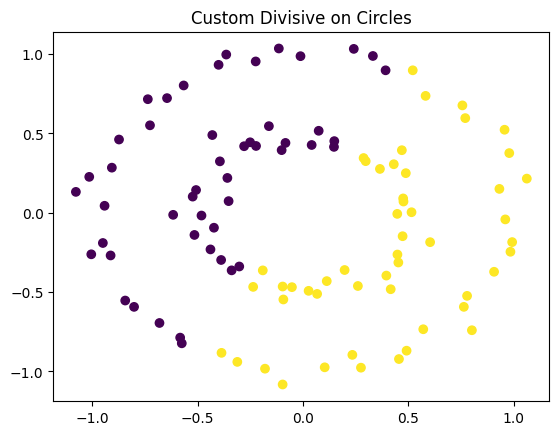

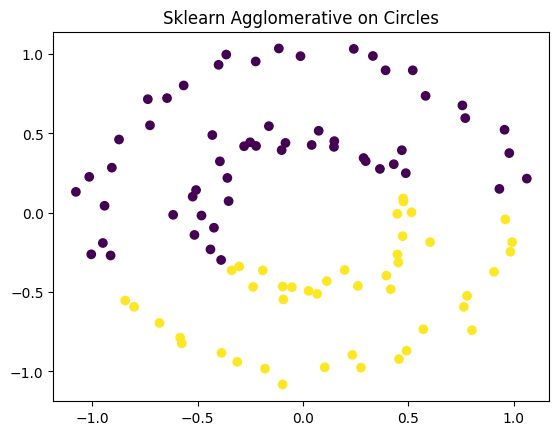

Adjusted Rand Index (Custom Divisive): -0.010
Adjusted Rand Index (Sklearn Agglomerative): -0.010


In [15]:
#Data and Plot function for make_circles
X, _ = make_circles(n_samples=100, noise=0.05, factor=0.5, random_state=42)

model = CustomDivisiveClustering(n_clusters=2)
model.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=model.labels_, cmap='viridis')
plt.title("Custom Divisive on Circles")
plt.show()

sk_model = SklearnAgglomerative(n_clusters=2)
y_sklearn = sk_model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=sk_model.labels_, cmap='viridis')
plt.title("Sklearn Agglomerative on Circles")
plt.show()

ari_divisive = adjusted_rand_score(_, model.labels_)
ari_sklearn = adjusted_rand_score(_, y_sklearn)

print(f"Adjusted Rand Index (Custom Divisive): {ari_divisive:.3f}")
print(f"Adjusted Rand Index (Sklearn Agglomerative): {ari_sklearn:.3f}")

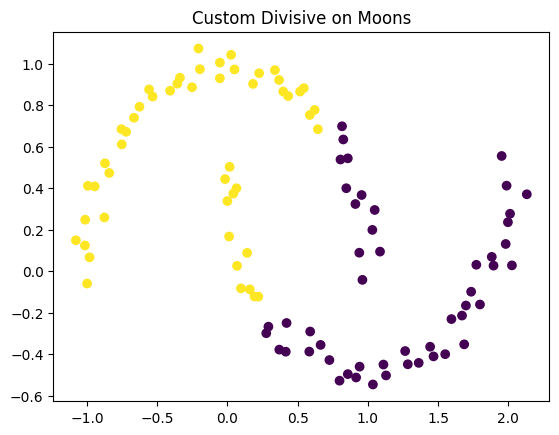

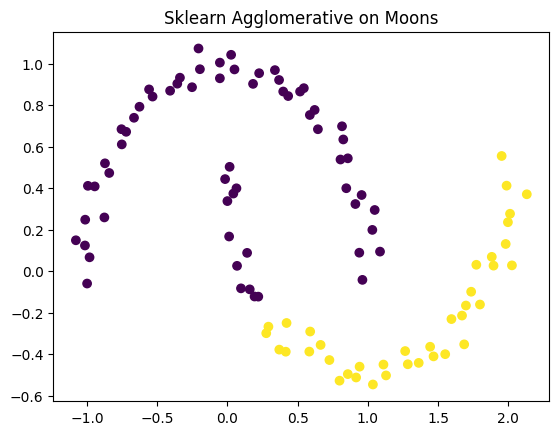

Adjusted Rand Index (Custom Divisive): 0.263
Adjusted Rand Index (Sklearn Agglomerative): -0.010


In [16]:
# Generate the moons dataset
X, _ = make_moons(n_samples=100, noise=0.05, random_state=42)

# Custom Divisive Clustering
model = CustomDivisiveClustering(n_clusters=2)
model.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=model.labels_, cmap='viridis')
plt.title("Custom Divisive on Moons")
plt.show()

# Sklearn Agglomerative Clustering
sk_model = SklearnAgglomerative(n_clusters=2)
sk_model.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=sk_model.labels_, cmap='viridis')
plt.title("Sklearn Agglomerative on Moons")
plt.show()

ari_divisive = adjusted_rand_score(_, model.labels_)
ari_sklearn = adjusted_rand_score(_, y_sklearn)

print(f"Adjusted Rand Index (Custom Divisive): {ari_divisive:.3f}")
print(f"Adjusted Rand Index (Sklearn Agglomerative): {ari_sklearn:.3f}")
